In [1]:
from env import get_db_url
import wrangle_zillow
import model
import utilities

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from matplotlib import rcParams

alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Acquire
df = wrangle_zillow.get_zillow()

Reading from csv file...


In [3]:
# Look at data
utilities.summary_info(df)

--- Shape: (77381, 67)
--- Descriptions
                   parcelid  airconditioningtypeid  architecturalstyletypeid  \
count             77,381.00              24,953.00                    206.00   
unique                  NaN                    NaN                       NaN   
top                     NaN                    NaN                       NaN   
freq                    NaN                    NaN                       NaN   
mean          13,007,150.51                   1.81                      7.39   
std            3,481,345.65                   2.97                      2.73   
min           10,711,855.00                   1.00                      2.00   
25%           11,538,305.00                   1.00                      7.00   
50%           12,531,568.00                   1.00                      7.00   
75%           14,211,831.00                   1.00                      7.00   
max          167,689,317.00                  13.00                     21.00   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77381 non-null  float64
 5   bedroomcnt                    77381 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49672 non-null  float64
 8   calculatedbathnbr             76772 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet12          73749 non-null  float64
 13  f

In [4]:
# To limit to single_family_homes
df =wrangle_zillow.single_family_homes(df)
df.shape

(71548, 67)

### Prep Phase
- Data Prep: Column data types are appropriate for the data they contain
- Data Prep: Missing values are investigated and handled

In [5]:
utilities.missing_values_per_column(df)

count              percent
buildingclasstypeid           71548                 1.00
buildingclassdesc             71548                 1.00
finishedsquarefeet15          71539                 1.00
finishedsquarefeet13          71522                 1.00
basementsqft                  71498                 1.00
storydesc                     71498                 1.00
storytypeid                   71498                 1.00
yardbuildingsqft26            71479                 1.00
finishedsquarefeet6           71392                 1.00
fireplaceflag                 71376                 1.00
architecturalstyletypeid      71342                 1.00
architecturalstyledesc        71342                 1.00
typeconstructiondesc          71326                 1.00
typeconstructiontypeid        71326                 1.00
pooltypeid10                  71085                 0.99
decktypeid                    70937                 0.99
poolsizesum                   70686                 0.99
pooltypeid2                   70474                 0.98
hashottuborspa                70011                 0.98
yardbuildingsqft17            69172                 0.97
taxdelinquencyyear            68964                 0.96
taxdelinquencyflag            68964                 0.96
finishedsquarefeet50          65550                 0.92
finishedfloor1squarefeet      65550                 0.92
fireplacecnt                  63305                 0.88
threequarterbathnbr           61458                 0.86
pooltypeid7                   57013                 0.80
poolcnt                       55921                 0.78
numberofstories               54237                 0.76
airconditioningtypeid         48699                 0.68
airconditioningdesc           48699                 0.68
garagecarcnt                  46278                 0.65
garagetotalsqft               46278                 0.65
regionidneighborhood          43631                 0.61
buildingqualitytypeid         26830                 0.37
propertyzoningdesc            26538                 0.37
unitcnt                       26512                 0.37
heatingorsystemtypeid         25262                 0.35
heatingorsystemdesc           25262                 0.35
lotsizesquarefeet              8039                 0.11
regionidcity                   1321                 0.02
censustractandblock             208                 0.00
finishedsquarefeet12            191                 0.00
structuretaxvaluedollarcnt       73                 0.00
regionidzip                      41                 0.00
yearbuilt                        35                 0.00
fullbathcnt                      15                 0.00
calculatedbathnbr                15                 0.00
taxamount                         5                 0.00
taxvaluedollarcnt                 1                 0.00
landtaxvaluedollarcnt             1                 0.00
logerror                          0                 0.00
transactiondate                   0                 0.00
propertylandusedesc               0                 0.00
parcelid                          0                 0.00
assessmentyear                    0                 0.00
roomcnt                           0                 0.00
regionidcounty                    0                 0.00
rawcensustractandblock            0                 0.00
propertycountylandusecode         0                 0.00
longitude                         0                 0.00
latitude                          0                 0.00
fips                              0                 0.00
calculatedfinishedsquarefeet      0                 0.00
bedroomcnt                        0                 0.00
bathroomcnt                       0                 0.00
propertylandusetypeid             0                 0.00

In [6]:
#Remove unused columns
df = utilities.remove_columns(df, cols_to_remove = ['censustractandblock','finishedsquarefeet12','buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc', 'unitcnt'])
df.head().T

0  \
parcelid                                       14297519   
airconditioningtypeid                               NaN   
architecturalstyletypeid                            NaN   
basementsqft                                        NaN   
bathroomcnt                                        3.50   
bedroomcnt                                         4.00   
buildingclasstypeid                                 NaN   
calculatedbathnbr                                  3.50   
decktypeid                                          NaN   
finishedfloor1squarefeet                            NaN   
calculatedfinishedsquarefeet                   3,100.00   
finishedsquarefeet13                                NaN   
finishedsquarefeet15                                NaN   
finishedsquarefeet50                                NaN   
finishedsquarefeet6                                 NaN   
fips                                           6,059.00   
fireplacecnt                                        NaN   
fullbathcnt                                        3.00   
garagecarcnt                                       2.00   
garagetotalsqft                                  633.00   
hashottuborspa                                      NaN   
latitude                                  33,634,931.00   
longitude                               -117,869,207.00   
lotsizesquarefeet                              4,506.00   
poolcnt                                             NaN   
poolsizesum                                         NaN   
pooltypeid10                                        NaN   
pooltypeid2                                         NaN   
pooltypeid7                                         NaN   
propertycountylandusecode                           122   
propertylandusetypeid                            261.00   
rawcensustractandblock                    60,590,630.07   
regionidcity                                  53,571.00   
regionidcounty                                 1,286.00   
regionidneighborhood                                NaN   
regionidzip                                   96,978.00   
roomcnt                                            0.00   
storytypeid                                         NaN   
threequarterbathnbr                                1.00   
typeconstructiontypeid                              NaN   
yardbuildingsqft17                                  NaN   
yardbuildingsqft26                                  NaN   
yearbuilt                                      1,998.00   
numberofstories                                     NaN   
fireplaceflag                                       NaN   
structuretaxvaluedollarcnt                   485,713.00   
taxvaluedollarcnt                          1,023,282.00   
assessmentyear                                 2,016.00   
landtaxvaluedollarcnt                        537,569.00   
taxamount                                     11,013.72   
taxdelinquencyflag                                  NaN   
taxdelinquencyyear                                  NaN   
logerror                                           0.03   
transactiondate                              2017-01-01   
airconditioningdesc                                 NaN   
architecturalstyledesc                              NaN   
buildingclassdesc                                   NaN   
propertylandusedesc           Single Family Residential   
storydesc                                           NaN   
typeconstructiondesc                                NaN   

                                                      1  \
parcelid                                       17052889   
airconditioningtypeid                               NaN   
architecturalstyletypeid                            NaN   
basementsqft                                        NaN   
bathroomcnt                                        1.00   
bedroomcnt                                         2.00   
buildingclasstypeid                      

In [7]:
# fix Lat/Longitude
df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000

In [8]:
#Missing values check
utilities.missing_values_per_column(df)

count              percent
buildingclasstypeid           71548                 1.00
buildingclassdesc             71548                 1.00
finishedsquarefeet15          71539                 1.00
finishedsquarefeet13          71522                 1.00
basementsqft                  71498                 1.00
storydesc                     71498                 1.00
storytypeid                   71498                 1.00
yardbuildingsqft26            71479                 1.00
finishedsquarefeet6           71392                 1.00
fireplaceflag                 71376                 1.00
architecturalstyletypeid      71342                 1.00
architecturalstyledesc        71342                 1.00
typeconstructiontypeid        71326                 1.00
typeconstructiondesc          71326                 1.00
pooltypeid10                  71085                 0.99
decktypeid                    70937                 0.99
poolsizesum                   70686                 0.99
pooltypeid2                   70474                 0.98
hashottuborspa                70011                 0.98
yardbuildingsqft17            69172                 0.97
taxdelinquencyflag            68964                 0.96
taxdelinquencyyear            68964                 0.96
finishedfloor1squarefeet      65550                 0.92
finishedsquarefeet50          65550                 0.92
fireplacecnt                  63305                 0.88
threequarterbathnbr           61458                 0.86
pooltypeid7                   57013                 0.80
poolcnt                       55921                 0.78
numberofstories               54237                 0.76
airconditioningdesc           48699                 0.68
airconditioningtypeid         48699                 0.68
garagetotalsqft               46278                 0.65
garagecarcnt                  46278                 0.65
regionidneighborhood          43631                 0.61
lotsizesquarefeet              8039                 0.11
regionidcity                   1321                 0.02
structuretaxvaluedollarcnt       73                 0.00
regionidzip                      41                 0.00
yearbuilt                        35                 0.00
fullbathcnt                      15                 0.00
calculatedbathnbr                15                 0.00
taxamount                         5                 0.00
landtaxvaluedollarcnt             1                 0.00
taxvaluedollarcnt                 1                 0.00
logerror                          0                 0.00
transactiondate                   0                 0.00
propertylandusedesc               0                 0.00
parcelid                          0                 0.00
assessmentyear                    0                 0.00
roomcnt                           0                 0.00
regionidcounty                    0                 0.00
rawcensustractandblock            0                 0.00
propertycountylandusecode         0                 0.00
longitude                         0                 0.00
latitude                          0                 0.00
fips                              0                 0.00
calculatedfinishedsquarefeet      0                 0.00
bedroomcnt                        0                 0.00
bathroomcnt                       0                 0.00
propertylandusetypeid             0                 0.00

In [9]:
utilities.missing_values_per_row(df)

n_cols_missing      percent_missing  row_counts
0               19                 0.32           2
1               20                 0.33           5
2               21                 0.35          24
3               22                 0.37          98
4               23                 0.38         310
5               24                 0.40         485
6               25                 0.42         569
7               26                 0.43        1069
8               27                 0.45        2845
9               28                 0.47        3929
10              29                 0.48        7886
11              30                 0.50        5949
12              31                 0.52       12937
13              32                 0.53       12546
14              33                 0.55       12302
15              34                 0.57       10112
16              35                 0.58         463
17              36                 0.60          13
18              37                 0.62           4

In [10]:
df = utilities.handle_missing_values(df, prop_required_column = .5, prop_required_row = .5)
df.shape

(71548, 26)

In [11]:
df = utilities.data_prep(df, prop_required_column=.5, prop_required_row=.5)

(62210, 37)


In [12]:
df.isna().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
propertylandusetypeid             0
rawcensustractandblock            0
regionidcity                      0
regionidcounty                    0
regionidzip                       0
roomcnt                           0
yearbuilt                         0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
assessmentyear                    0
landtaxvaluedollarcnt             0
taxamount                         0
logerror                          0
transactiondate                   0
propertylandusedesc               0
county_code_bin                   0
county_code_bin_Orange Count

### Data Prep: Outliers are investigated and handled

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62210 entries, 0 to 77380
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   parcelid                        62210 non-null  int64   
 1   bathroomcnt                     62210 non-null  float64 
 2   bedroomcnt                      62210 non-null  float64 
 3   calculatedbathnbr               62210 non-null  float64 
 4   calculatedfinishedsquarefeet    62210 non-null  float64 
 5   fips                            62210 non-null  float64 
 6   fullbathcnt                     62210 non-null  float64 
 7   latitude                        62210 non-null  float64 
 8   longitude                       62210 non-null  float64 
 9   lotsizesquarefeet               62210 non-null  float64 
 10  propertycountylandusecode       62210 non-null  object  
 11  propertylandusetypeid           62210 non-null  float64 
 12  rawcensustractandb

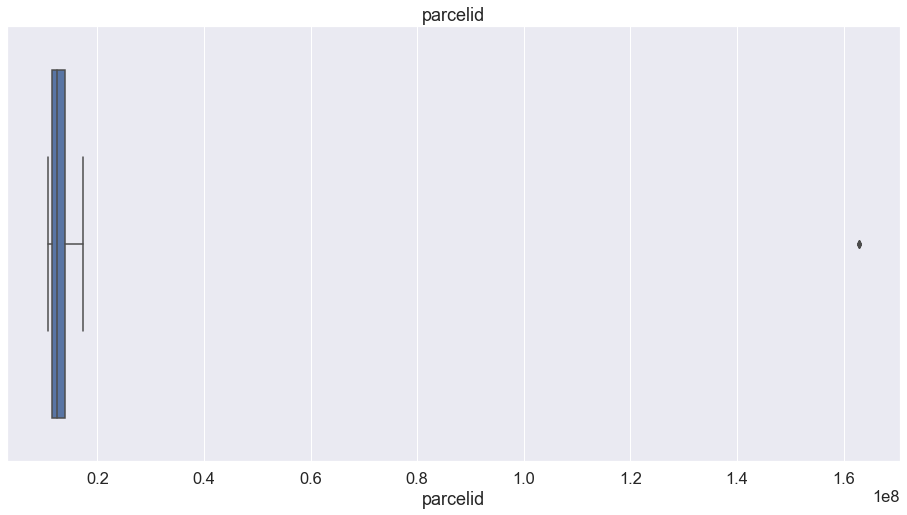

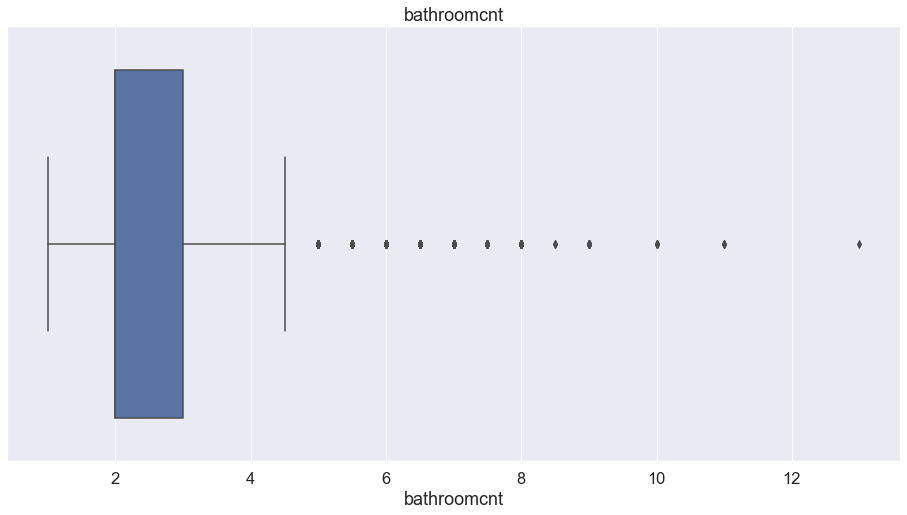

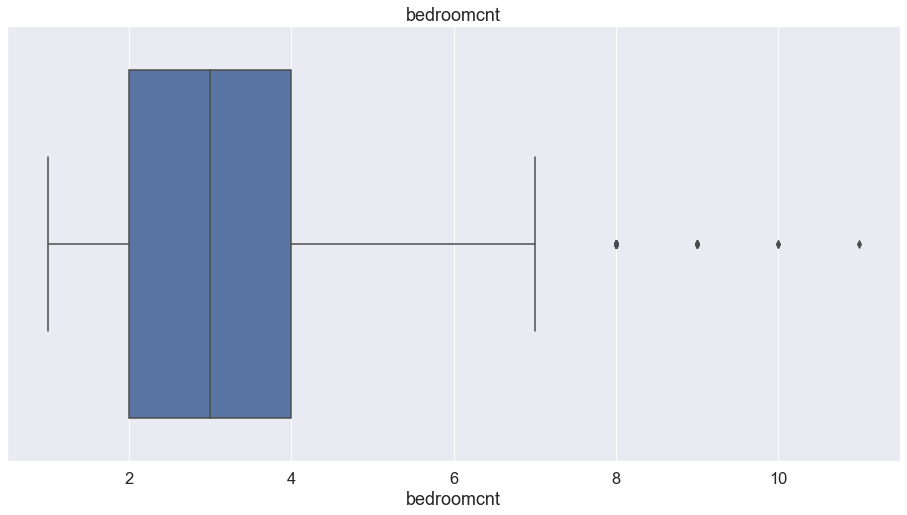

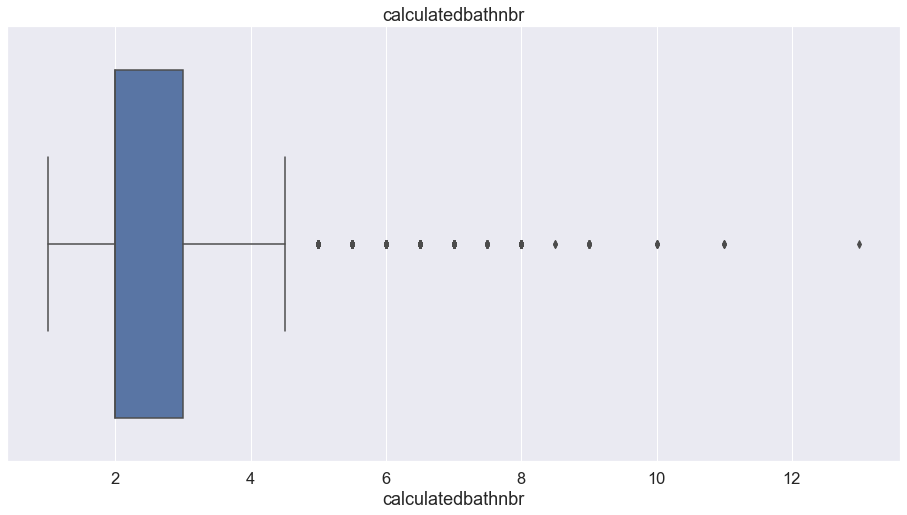

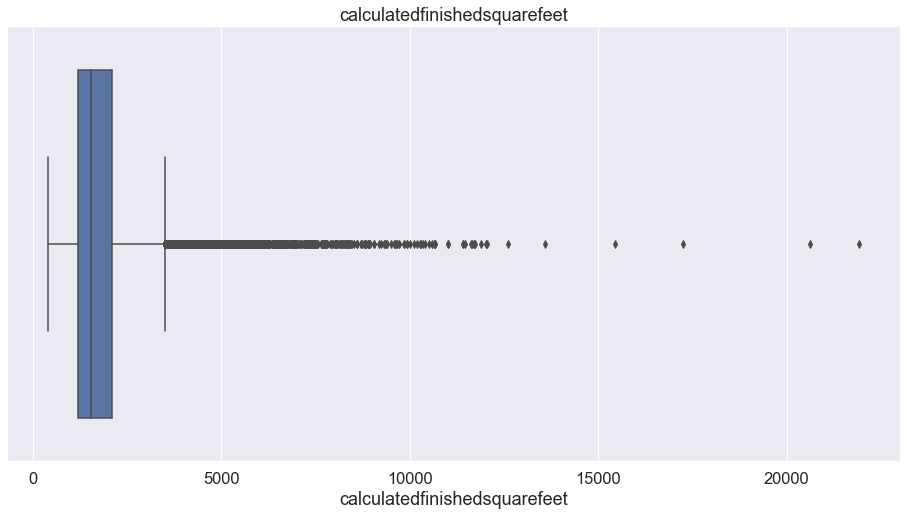

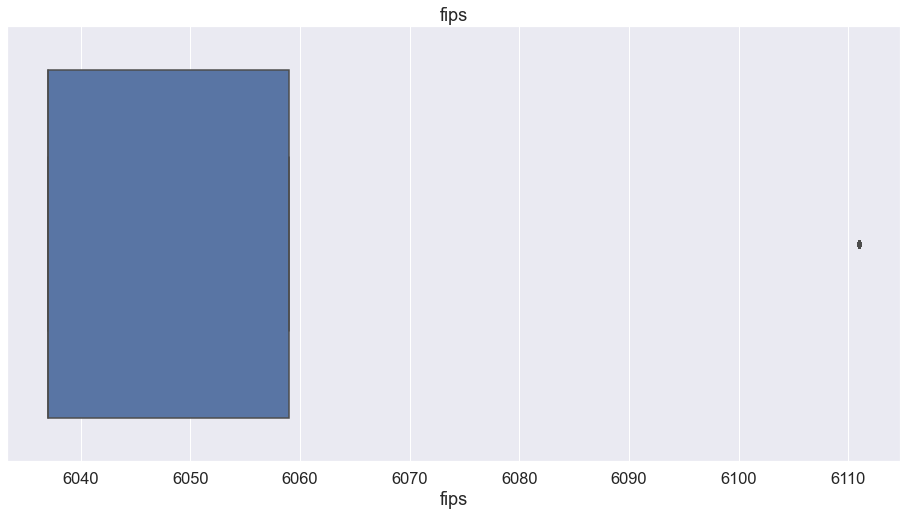

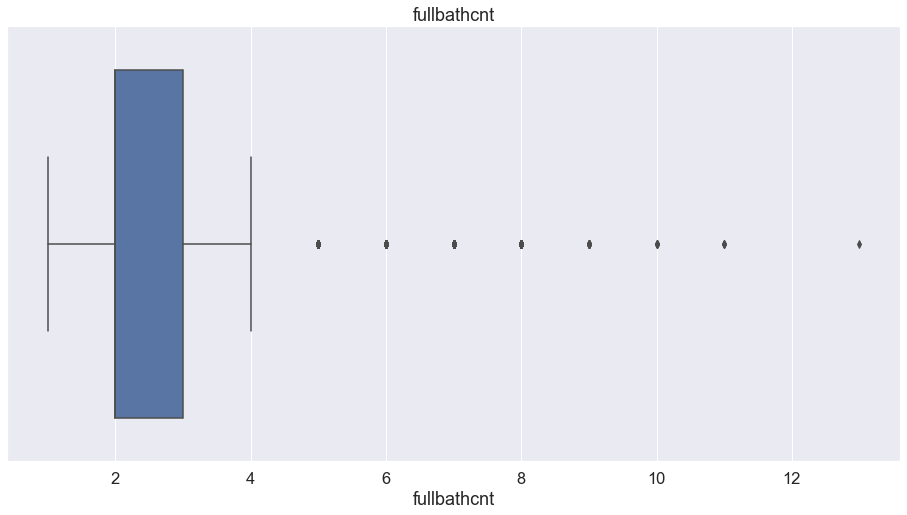

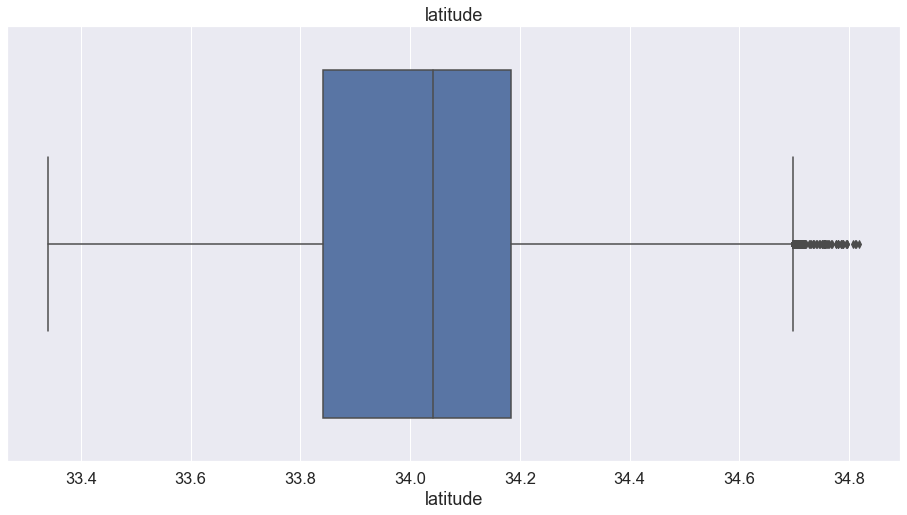

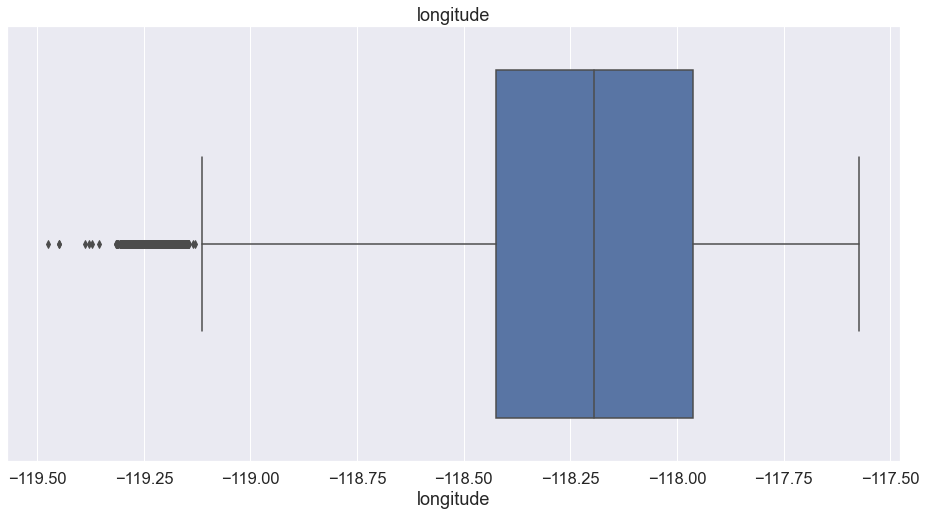

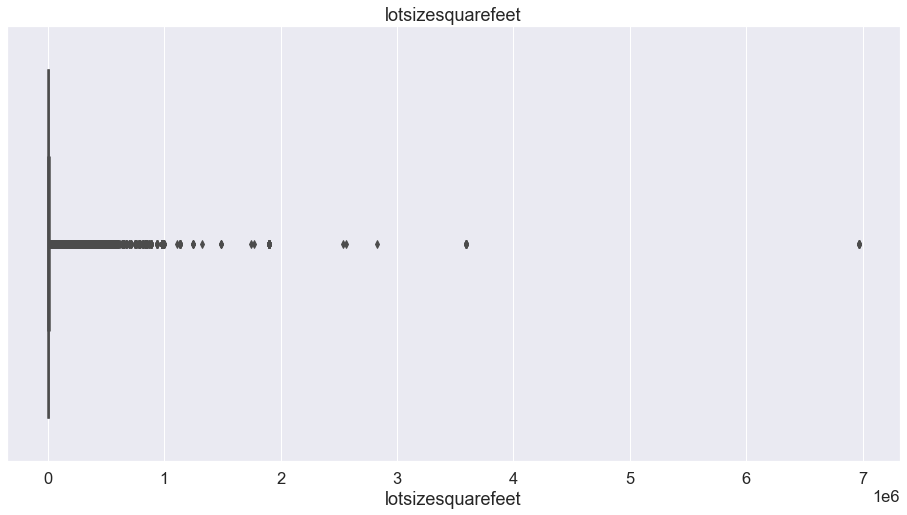

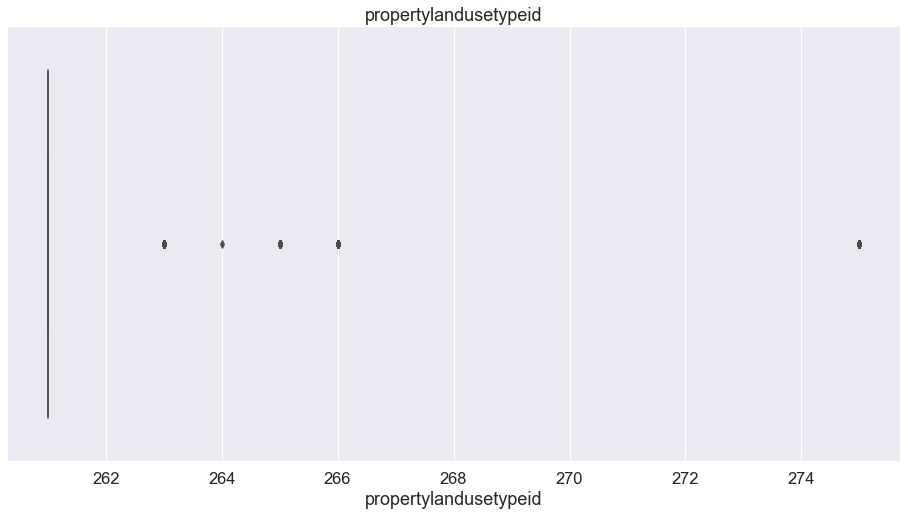

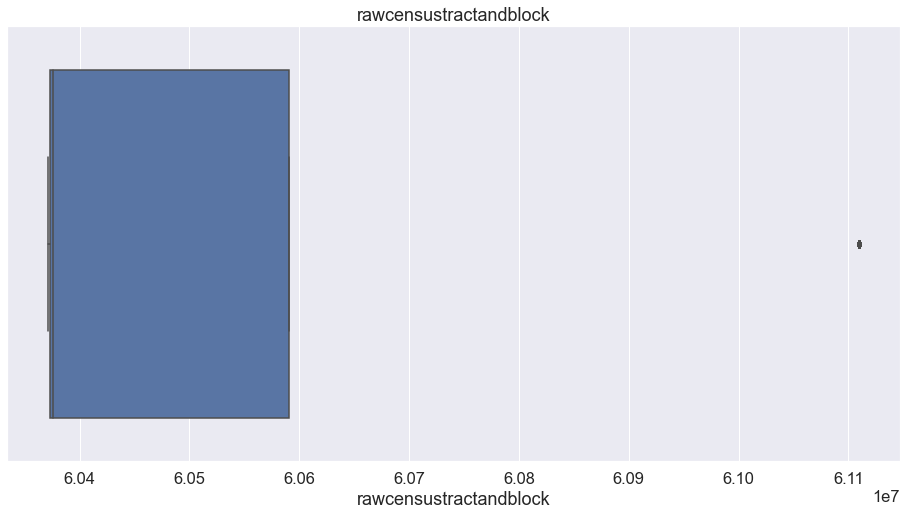

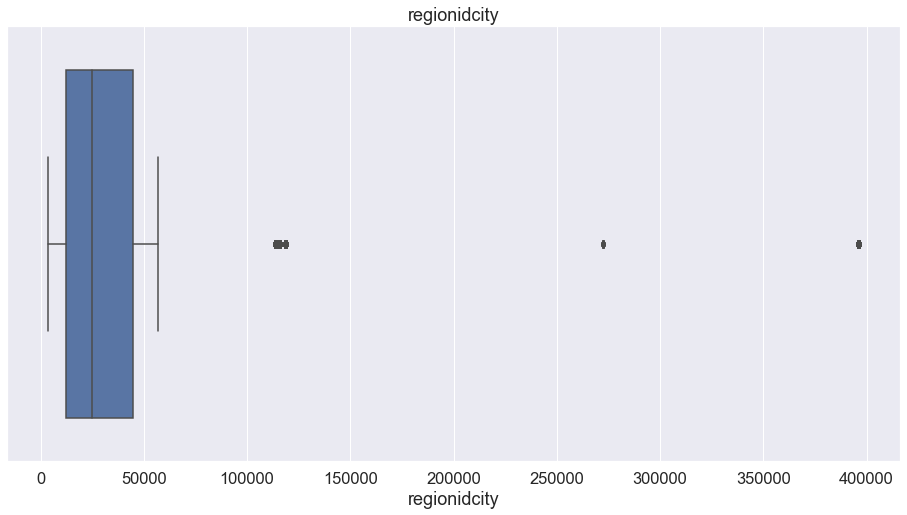

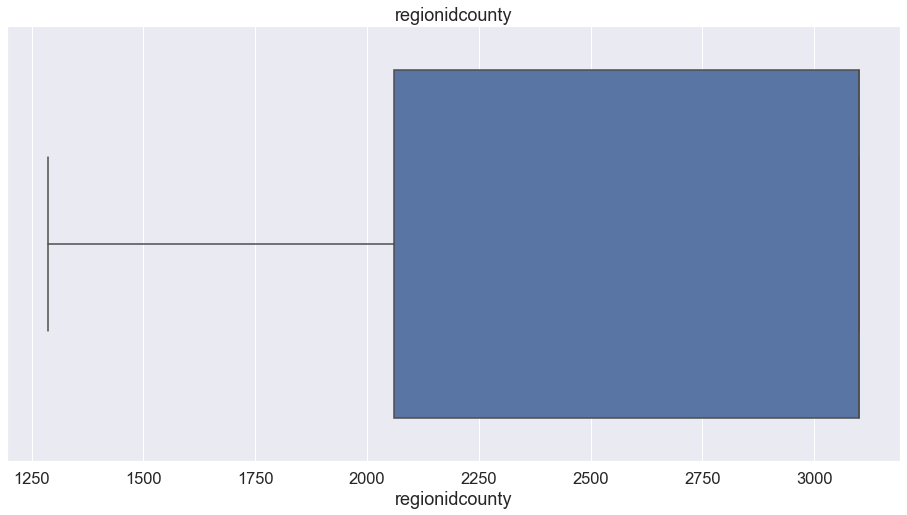

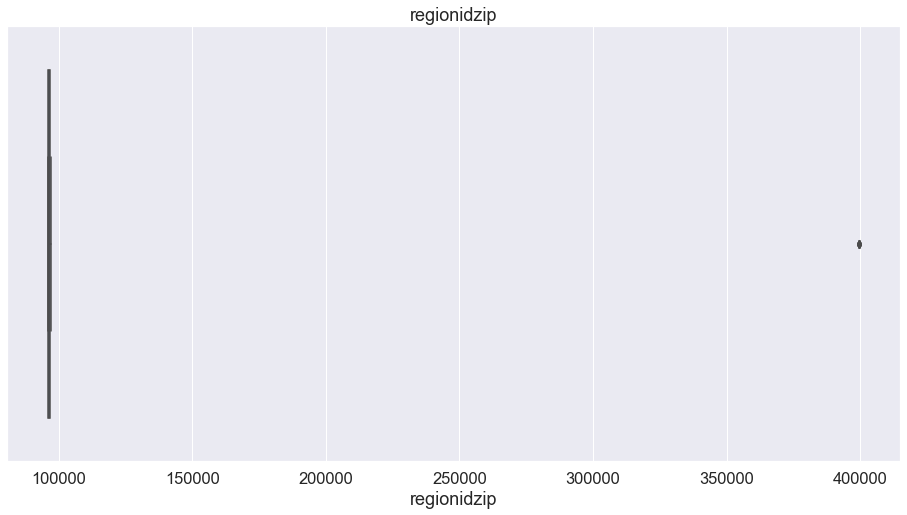

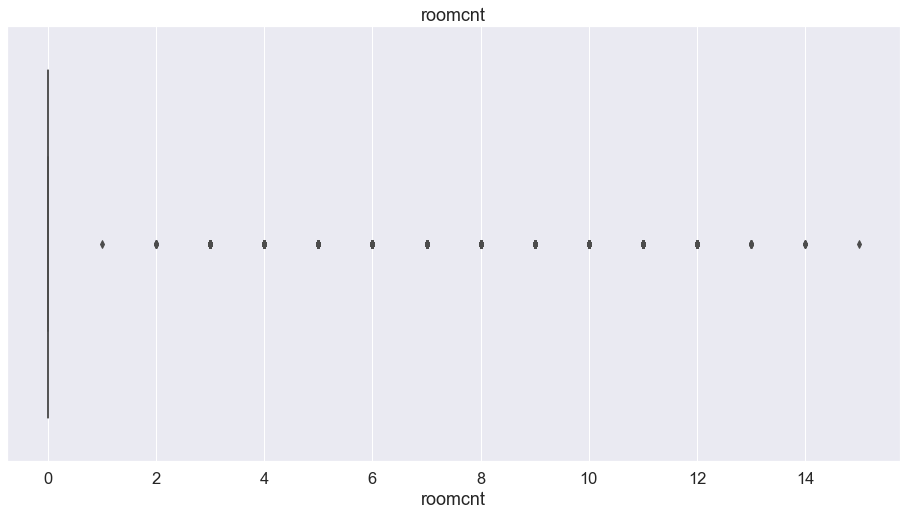

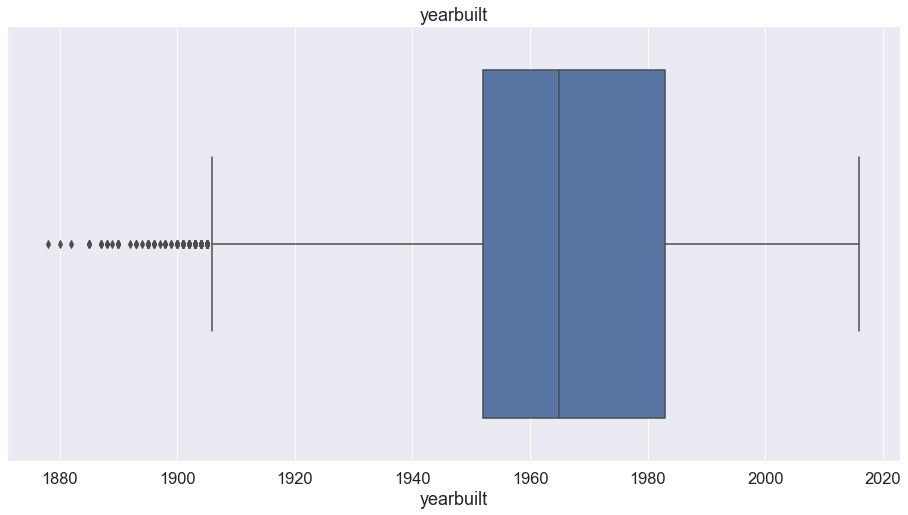

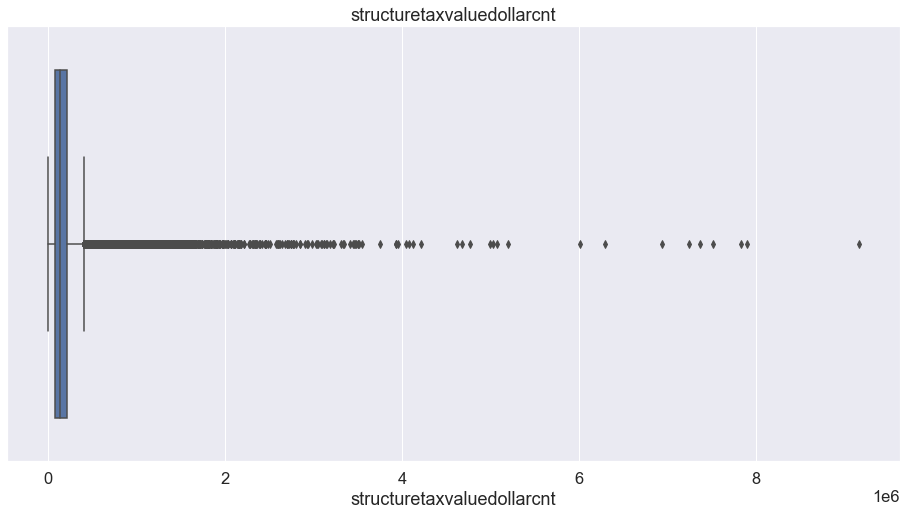

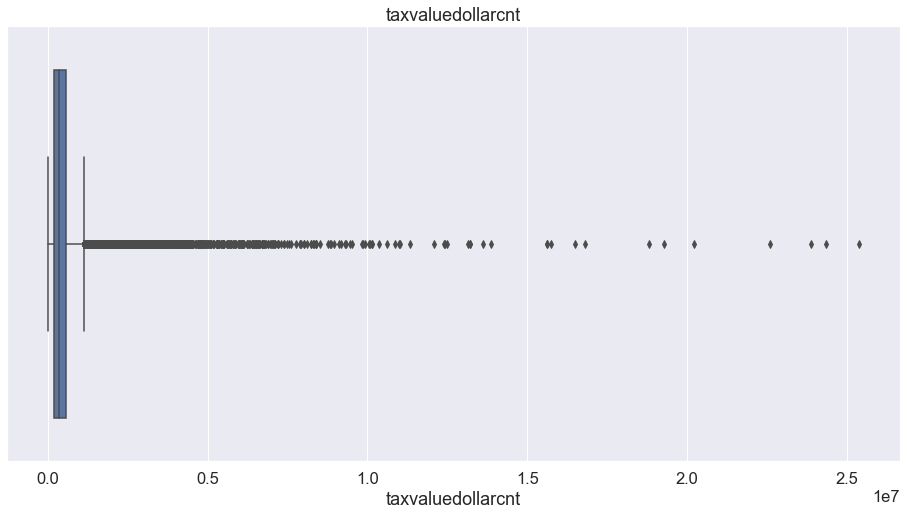

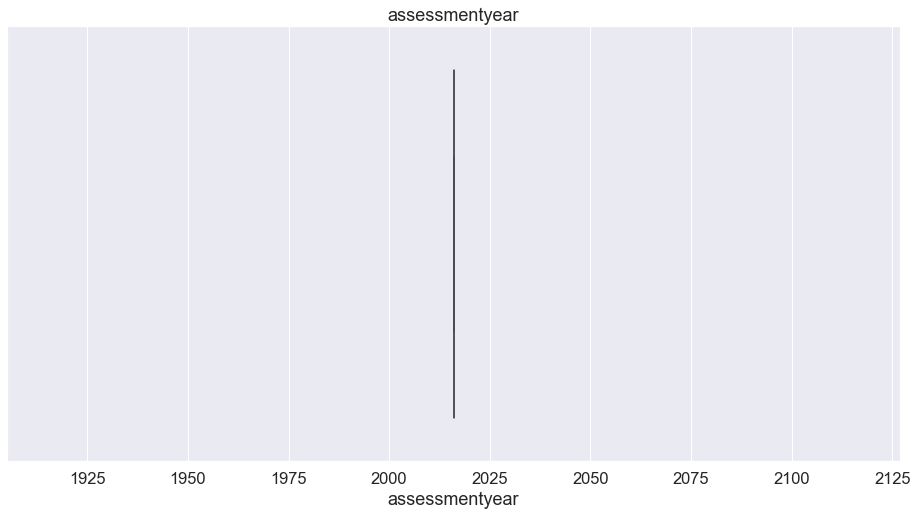

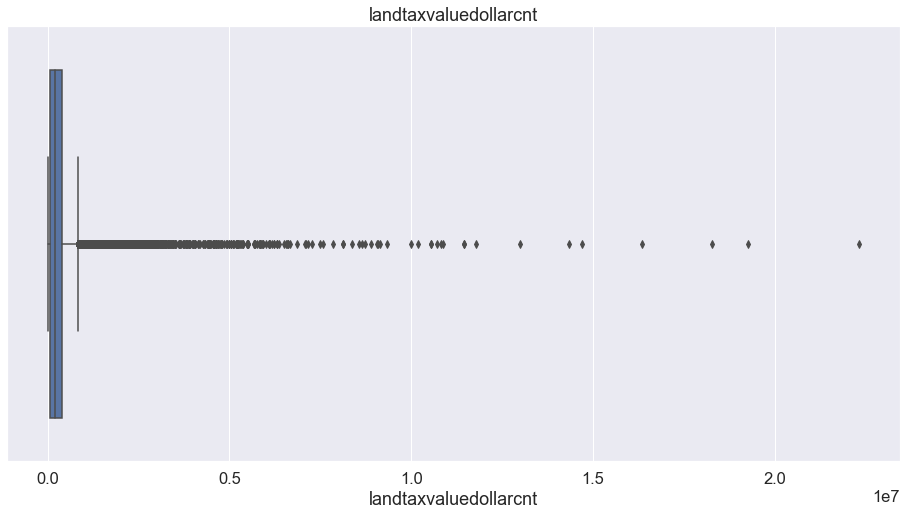

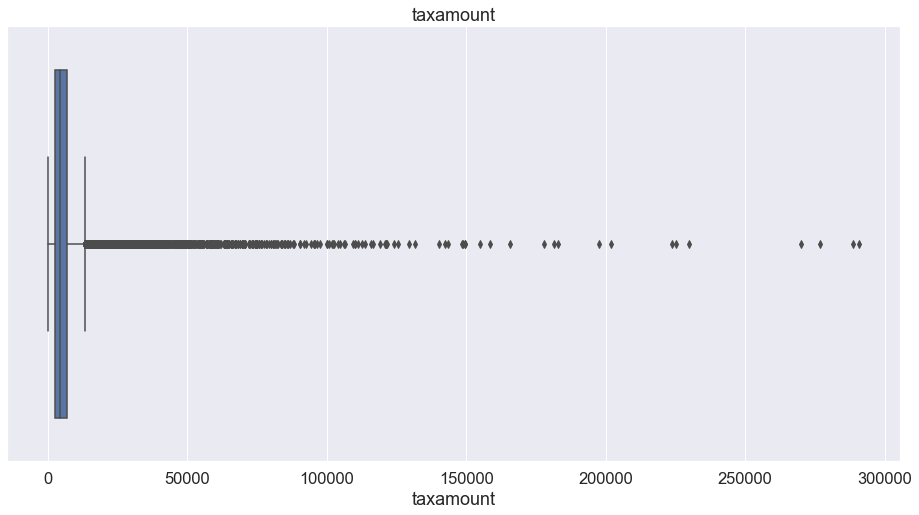

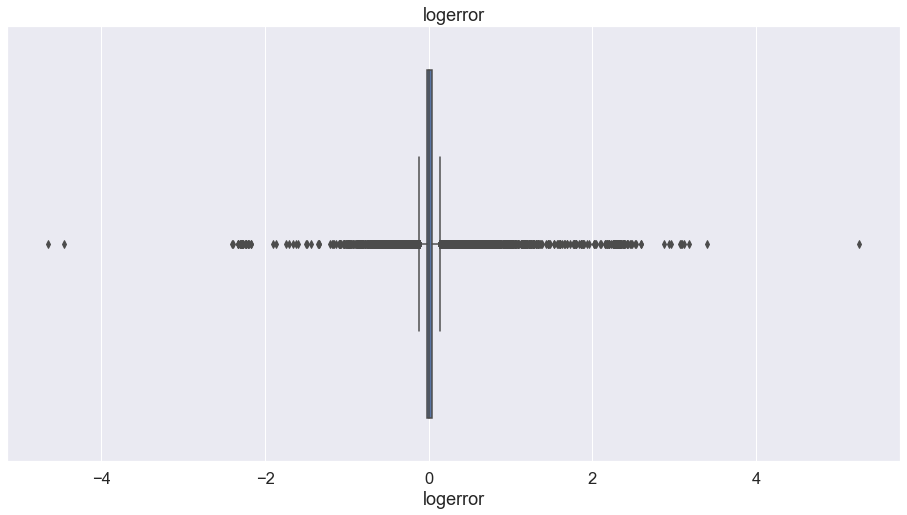

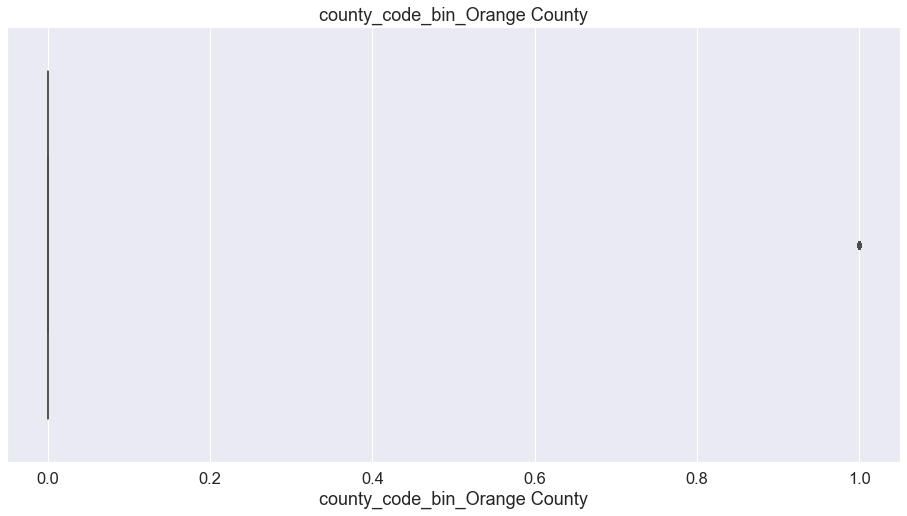

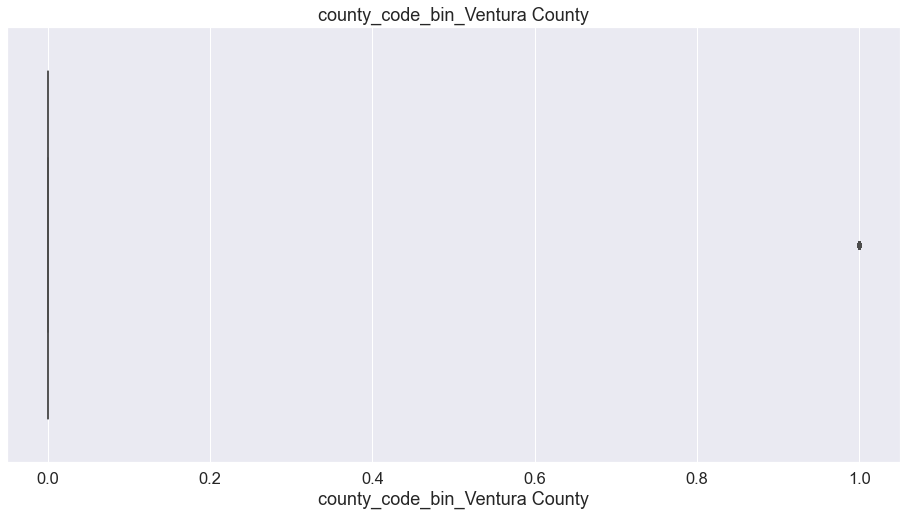

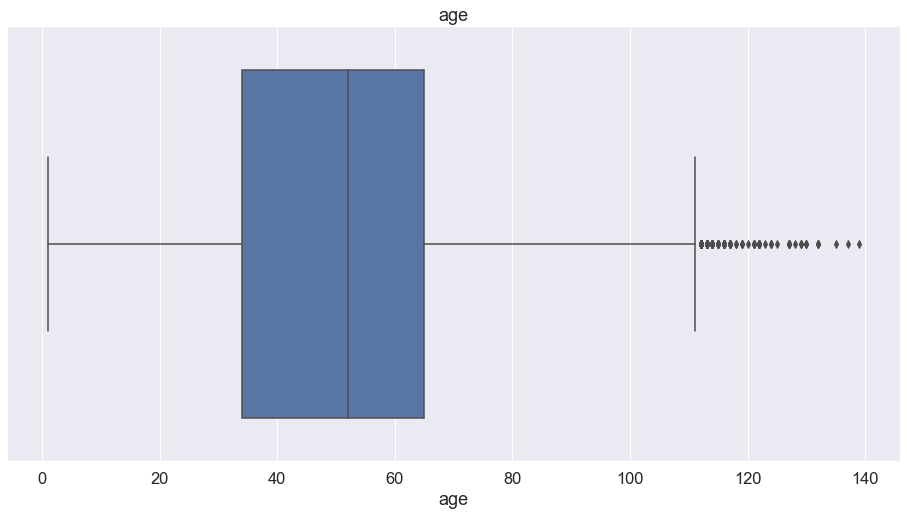

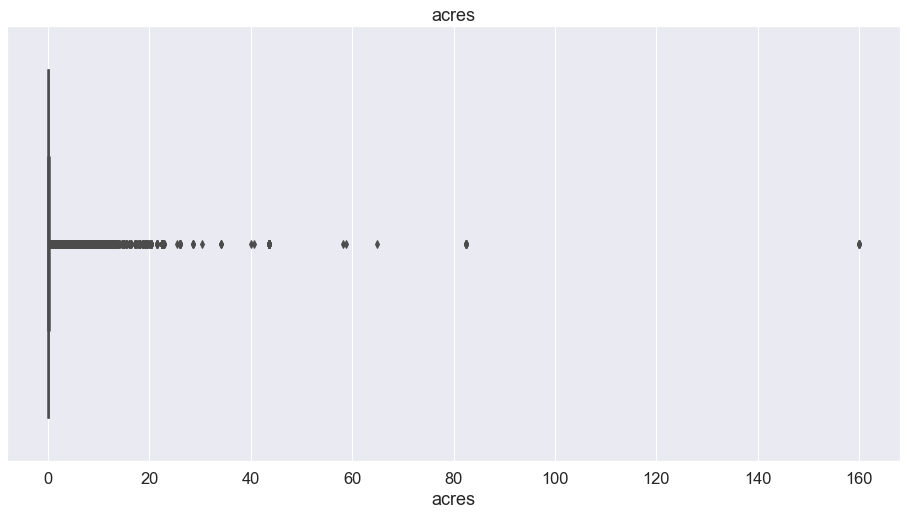

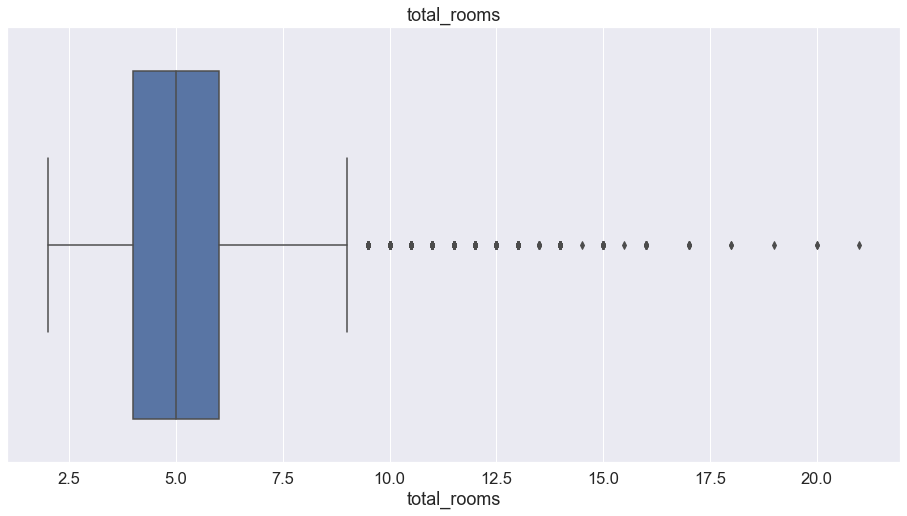

In [14]:
for col in df.select_dtypes('number'):
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [15]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate',
       'propertylandusedesc', 'county_code_bin',
       'county_code_bin_Orange County', 'county_code_bin_Ventura County',
       'age', 'age_bin', 'home_sizes', 'acres', 'acres_bin', 'total_rooms',
       'bedroom_bins', 'bathroom_bins'],
      dtype='object')

In [16]:
#Columns to investigate upper/lower outliers
columns = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'lotsizesquarefeet', 'propertycountylandusecode',
          'roomcnt', 'yearbuilt','structuretaxvaluedollarcnt', 'taxvaluedollarcnt']
# Upper outliers in roomcnt, lotsizesquarefeet, calculatedfinishedsquarefeet
#utitlities.get_upper_outliers('bathroomcnt',3.0).value_counts()

In [17]:
# Remove outliers in bath, bedroom, squarefeet, lotsize, and tax value using IQR approch. K=3.0 to limit data removal to <20% 
# Keeping it around the rubric lines of data 52,442 
df= utilities.remove_outliers(df, 3.0, ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','taxvaluedollarcnt'])

Number of observations removed: 9979


In [18]:
# Add abs_logerror for future analysis
df['abs_logerror'] = abs(df["logerror"])

In [19]:
df.shape

(52231, 38)

## Exploration Phase
 - Key attributes
 - only particular data will be analyzed based on extensive analysis.  See this [link](https://github.com/bradgauvin/clustering-exercises/blob/main/explore_zillow.ipynb "Extensive Analysis") for extensive analysis.  Only some factors will be explored. 
 
 - Quick univariate analysis to understand data
 - Quick bivariate analysis on size variables and value variables
 
 ### Key questions for EDA
  - How do variables correlate?
  - How does `logerror` relate with geography? 
  - How do 'logerror' and `acres` vary by `county`?
  - What categories have statistically significant absolute log errors greater than overall mean?
  
 ### Scaled Data Analysis
 

#### Split Data

In [20]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [21]:
train.shape, validate.shape, test.shape

((29248, 38), (12536, 38), (10447, 38))

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29248 entries, 36995 to 38092
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   parcelid                        29248 non-null  int64   
 1   bathroomcnt                     29248 non-null  float64 
 2   bedroomcnt                      29248 non-null  float64 
 3   calculatedbathnbr               29248 non-null  float64 
 4   calculatedfinishedsquarefeet    29248 non-null  float64 
 5   fips                            29248 non-null  float64 
 6   fullbathcnt                     29248 non-null  float64 
 7   latitude                        29248 non-null  float64 
 8   longitude                       29248 non-null  float64 
 9   lotsizesquarefeet               29248 non-null  float64 
 10  propertycountylandusecode       29248 non-null  object  
 11  propertylandusetypeid           29248 non-null  float64 
 12  rawcensustract

### Univariate Exploration

Text(0.5, 0, 'Log Error')

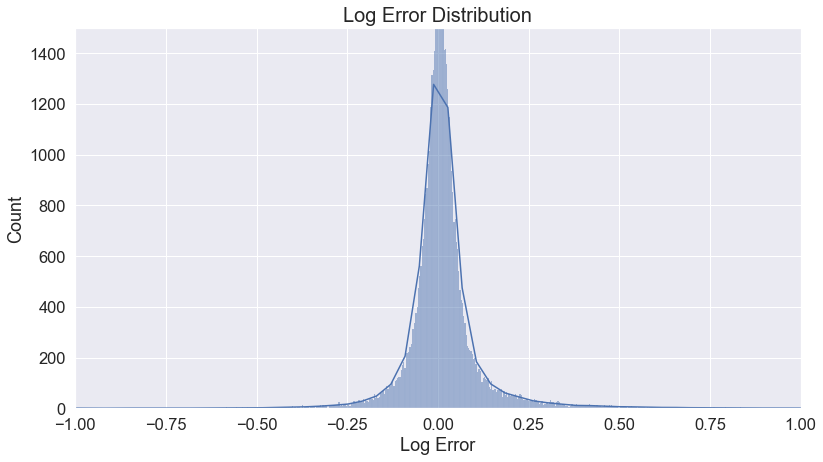

In [23]:
# Set size of figure
plt.figure(figsize = (13,7))
# Create histogram
ax = sns.histplot(data=df, x="logerror", kde=True)
# set x and y limits to 'zoom in'
ax.set(xlim = (-1, 1), ylim = (0, 1500)) # set the limits to the desired ones

plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

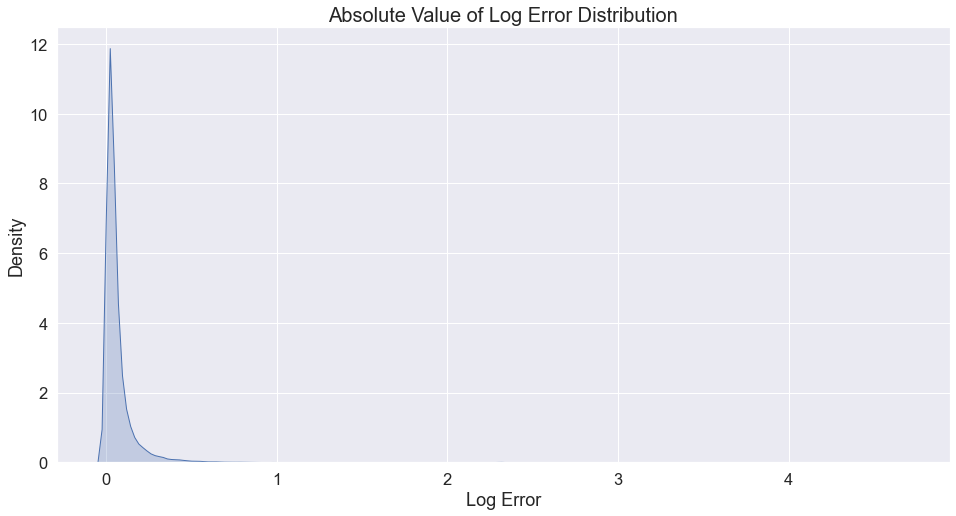

In [24]:
# absolute value of logerror
sns.kdeplot(df.logerror.abs(), shade=True)

plt.title('Absolute Value of Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

plt.show()

#### Bivariate

In [25]:
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

<Figure size 936x504 with 0 Axes>

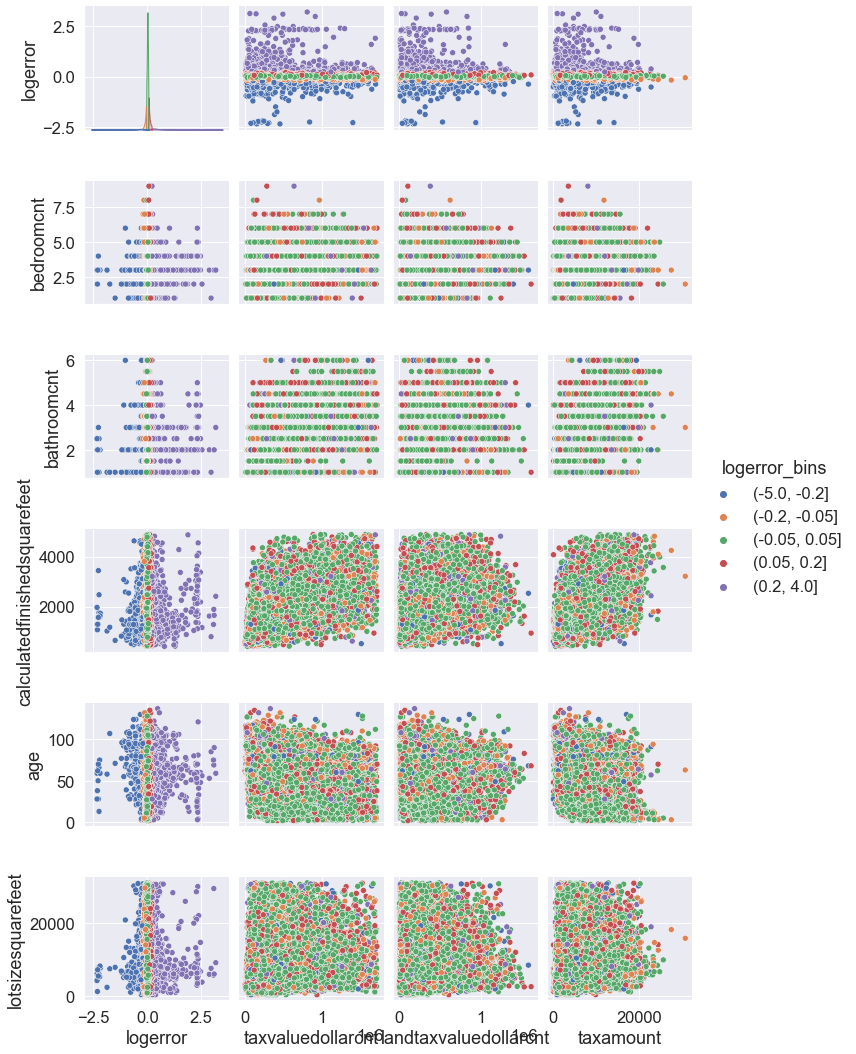

In [26]:
plt.figure(figsize = (13,7))
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'],
             y_vars = ['logerror', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'age', 'lotsizesquarefeet'])

### Takeaway
 - `Logerror` clusters possible in:
     - bedrooms
     - bathrooms
     - age
     - sqft dimentions (finished, lot, etc.)
     - value numbers (tax, land,taxed amount)

### Question 1:
### How do the variables correlate to target `logerror`?

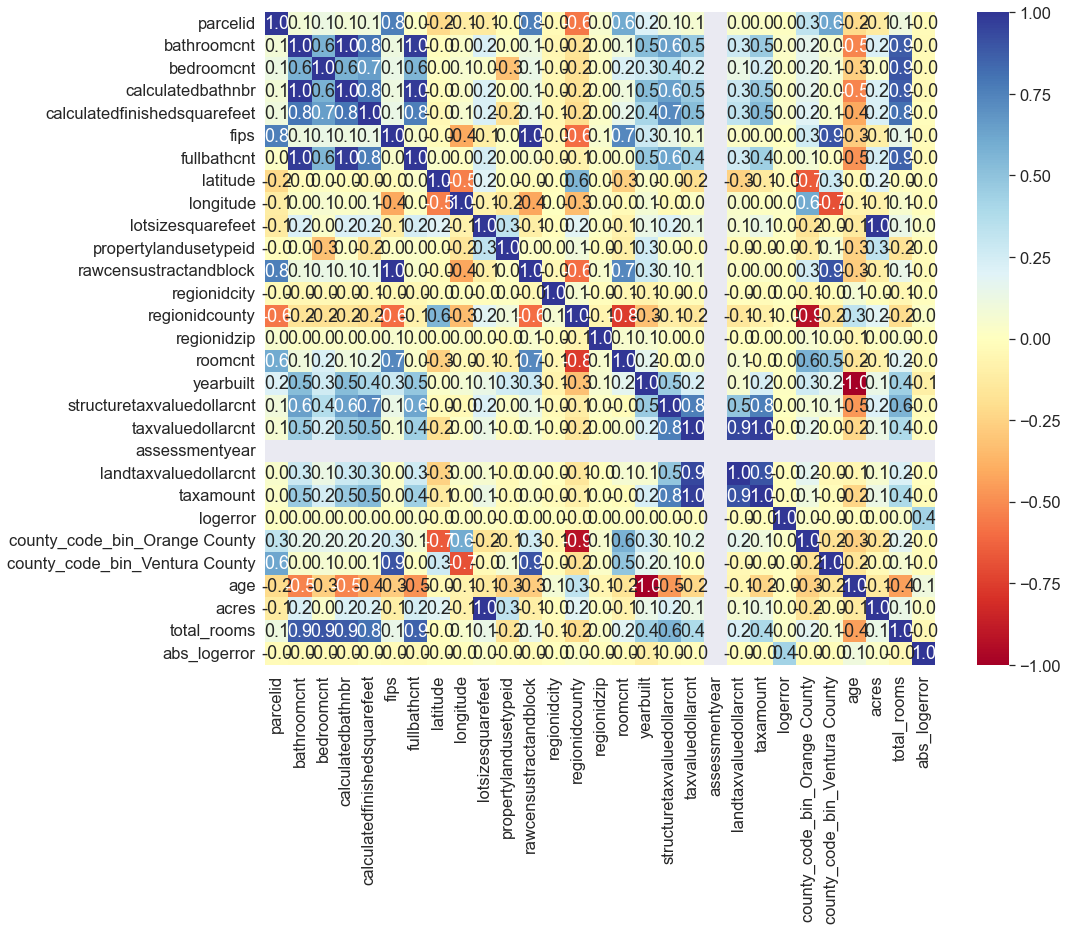

In [27]:
# Heatmap to display correlation of the features and logerror.
plt.figure(figsize = (15, 12))
sns.heatmap(df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

### Correlation Takeaway
- Nothing is related to `logerror`
- Possible correlations, just need to see it in different perspective.

### Question 2:
### How does `logerror` relate with geography?

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

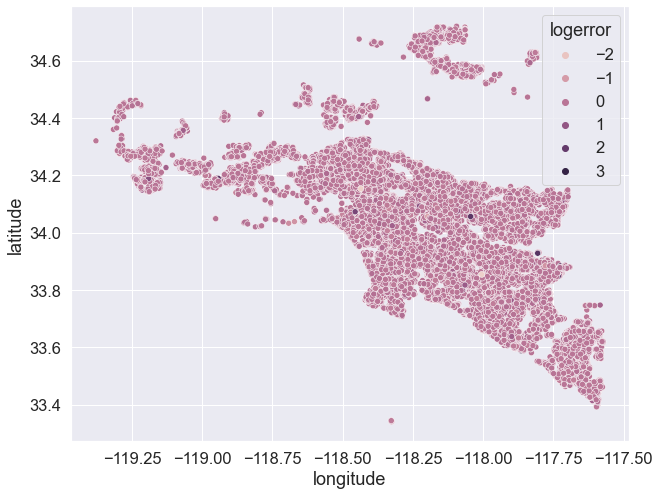

In [28]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x='longitude',y='latitude',hue='logerror')

### Question 3
### How do 'logerror' and acres vary by county?

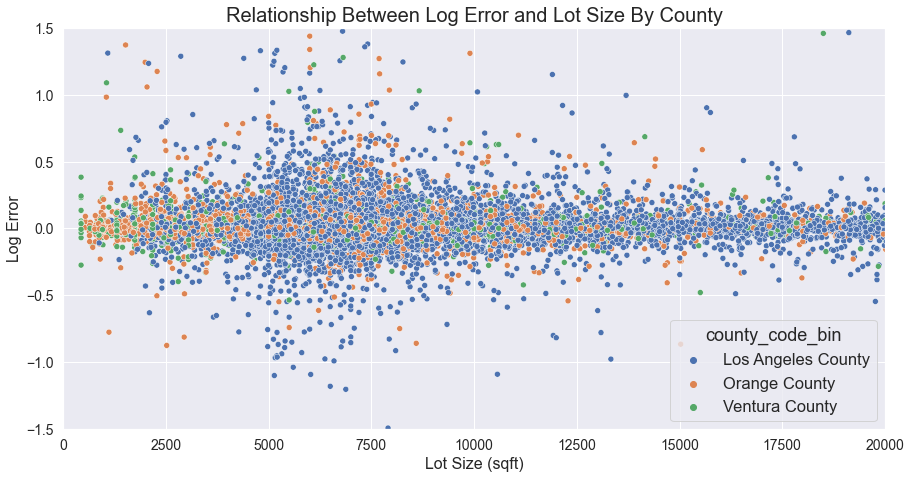

In [29]:
# acres didn't provide useful data... switched to lot sqft
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.title('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.xlabel('Lot Size (sqft)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

<Figure size 936x504 with 0 Axes>

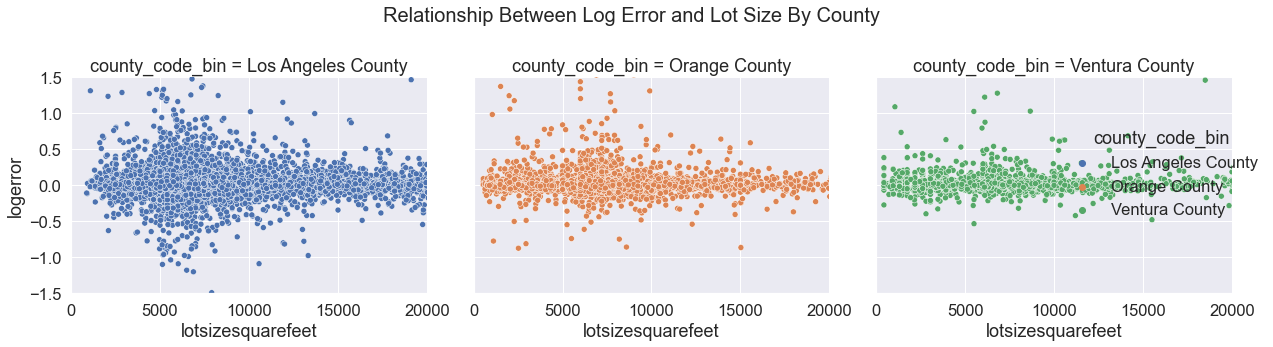

In [30]:
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

Text(0.5, 1.0, 'County v. Log Error')

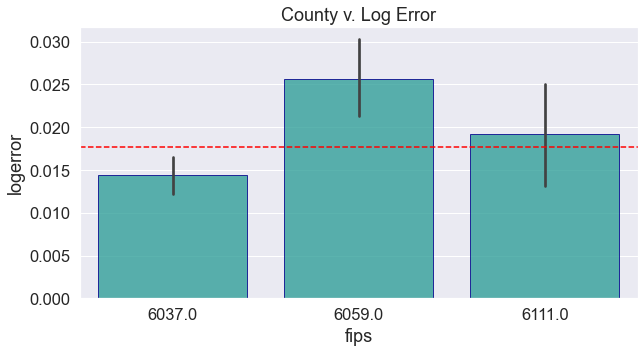

In [31]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.fips, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('County v. Log Error')

#### Takeaway:
 - possible correlation as LA county has more logerrors
 - Possible difference between lot size... need hypothesis testing!

In [32]:
# H0 - There is no linear relationship between lot size and logerror.
# H1 - There is a linear realtionship between lot size and log error.
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.013285493817789484
p = 0.023080802668538656
We reject the H0.


#### What about by county?

In [33]:
train.groupby('county_code_bin').apply(lambda subset: stats.pearsonr(subset.lotsizesquarefeet, subset.logerror))

county_code_bin
Los Angeles County      (0.013027653222859363, 0.07207071907945671)
Orange County         (0.036183161376448204, 0.0017777038258515317)
Ventura County           (0.022230915366154406, 0.2457485602363546)
dtype: object

### Hypothesis comparing all three counties (ANOVA)
- HO: There is no significant difference in logerror between LA, orange, and ventura county.
- Ha Logerror is significantly different between counties.

In [34]:
α = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6111], train.logerror[train.fips == 6037], train.logerror[train.fips == 6059])
F, p

(12.373894152631467, 4.249702539468095e-06)

In [35]:
null_hypothesis = 'there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County


### Takeaway:
 - lot size and is variable for LA and Ventura county

### Question 4
### What is overall mean logerror?
 - Used as a baseline logerror overall
 - Needed to find which features are above this overall mean

In [36]:
# create abs_logerror column - need to add prior to split.
# train['abs_logerror'] = abs(train["logerror"])

In [37]:
overall_mean = train.logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].logerror, train.logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size})
                                      

Overall mean logerror: 0.017734656591149353


In [38]:
high_log_errors.sort_values(by='difference_from_overall', ascending=False).head(15)

column                   option  \
14                  logerror_bins               (0.2, 4.0]   
13                  logerror_bins              (0.05, 0.2]   
9                      home_sizes   Large: 4000 - 5999sqft   
12                  bathroom_bins     Large: 5-6 bathrooms   
4                     fullbathcnt                     4.00   
10                   bedroom_bins      Large: 5-6 bedrooms   
1                      bedroomcnt                     5.00   
2                            fips                 6,059.00   
5                  regionidcounty                 1,286.00   
6                 county_code_bin            Orange County   
7   county_code_bin_Orange County                        1   
0                      bedroomcnt                     4.00   
11                  bathroom_bins    Medium: 3-4 bathrooms   
8                      home_sizes  Medium: 1800 - 3999sqft   
3                     fullbathcnt                     3.00   

         mean_log_error  difference_from_overall  option_sample_size  
14                 0.48                     0.46                1263  
13                 0.09                     0.08                4671  
9                  0.07                     0.05                 342  
12                 0.04                     0.03                 525  
4                  0.04                     0.02                1204  
10                 0.03                     0.01                1859  
1                  0.03                     0.01                1649  
2                  0.03                     0.01                7457  
5                  0.03                     0.01                7457  
6                  0.03                     0.01                7457  
7                  0.03                     0.01                7457  
0                  0.02                     0.01                7825  
11                 0.02                     0.01                9837  
8                  0.02                     0.00               10470  
3                  0.02                     0.00                6605

### Takeaways based on t-test with high positive error differences:
- Larger home sizes
- Larger bathrooms
- Larger Bedrooms 

- Larger homes have seem to be key factor 

### Scaling key data by groups for clustering
- Scale first then Variable selection, then explore scaled data

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29248 entries, 36995 to 38092
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   parcelid                        29248 non-null  int64   
 1   bathroomcnt                     29248 non-null  float64 
 2   bedroomcnt                      29248 non-null  float64 
 3   calculatedbathnbr               29248 non-null  float64 
 4   calculatedfinishedsquarefeet    29248 non-null  float64 
 5   fips                            29248 non-null  float64 
 6   fullbathcnt                     29248 non-null  float64 
 7   latitude                        29248 non-null  float64 
 8   longitude                       29248 non-null  float64 
 9   lotsizesquarefeet               29248 non-null  float64 
 10  propertycountylandusecode       29248 non-null  object  
 11  propertylandusetypeid           29248 non-null  float64 
 12  rawcensustract

In [40]:
# Scale everything and select features
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror','county_code_bin_Orange County', 'county_code_bin_Ventura County',
       'age','acres', 'total_rooms'])

In [41]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29248 entries, 36995 to 38092
Data columns (total 66 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   parcelid                               29248 non-null  int64   
 1   bathroomcnt                            29248 non-null  float64 
 2   bedroomcnt                             29248 non-null  float64 
 3   calculatedbathnbr                      29248 non-null  float64 
 4   calculatedfinishedsquarefeet           29248 non-null  float64 
 5   fips                                   29248 non-null  float64 
 6   fullbathcnt                            29248 non-null  float64 
 7   latitude                               29248 non-null  float64 
 8   longitude                              29248 non-null  float64 
 9   lotsizesquarefeet                      29248 non-null  float64 
 10  propertycountylandusecode              29248 non-null 

In [42]:
home_scale = (['bathroomcnt_scaled','bedroomcnt_scaled','calculatedfinishedsquarefeet_scaled','lotsizesquarefeet_scaled','age_scaled'])
price_scale = (['taxvaluedollarcnt_scaled','landtaxvaluedollarcnt_scaled','taxamount_scaled','age_scaled'])
key_variables_scale = (['age_scaled','calculatedfinishedsquarefeet_scaled','taxvaluedollarcnt_scaled'])

In [43]:
X = train_scaled[key_variables_scale]


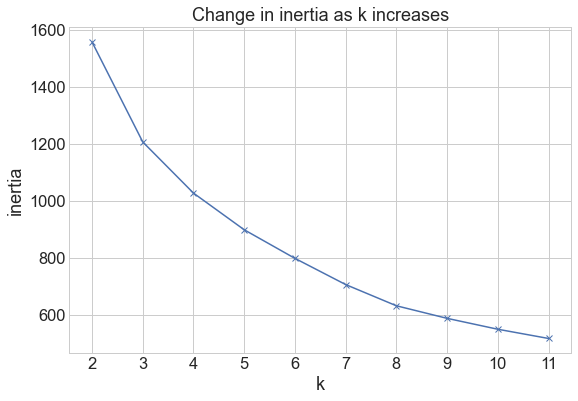

In [44]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Choose K3 , though no real bend

In [45]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(X)

train_scaled['age_size_value_cluster'] = kmeans.predict(X)
train_scaled.age_size_value_cluster = train_scaled.age_size_value_cluster.astype('category')

Text(0.5, 0, 'Cluster')

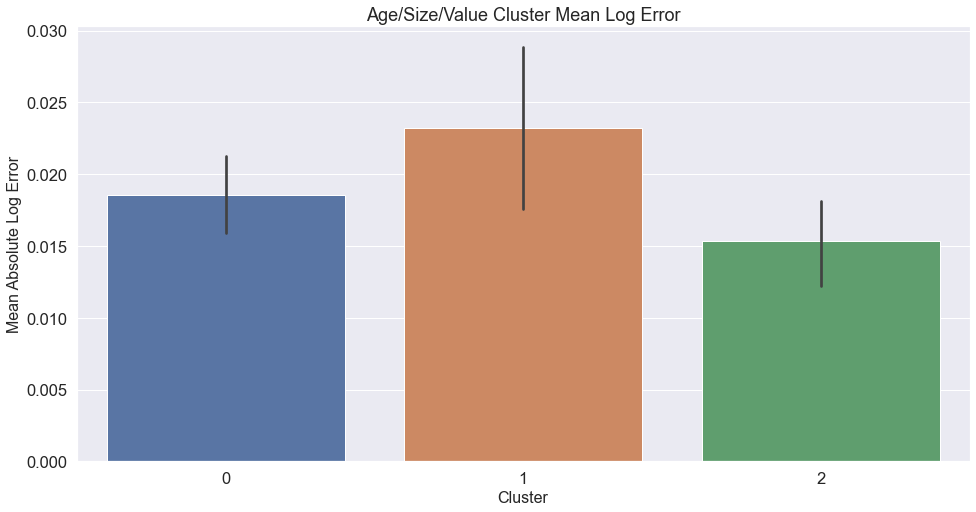

In [46]:
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'age_size_value_cluster', y='logerror')
plt.title("Age/Size/Value Cluster Mean Log Error")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

In [47]:
overall_mean = train_scaled.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.age_size_value_cluster):
    sample = train_scaled[train_scaled.age_size_value_cluster==col]
    t, p = stats.ttest_1samp(sample.logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.017734656591149353
0 Significant?  False t value:  0.6316462191820209
1 Significant?  False t value:  1.9165972040488544
2 Significant?  False t value:  -1.6041616686988496


#### Not significant... will plot for practice

Text(0.5, 1.0, 'Cluster 0 is young and small, Cluster 1 is young and large size, Cluster 2 is older')

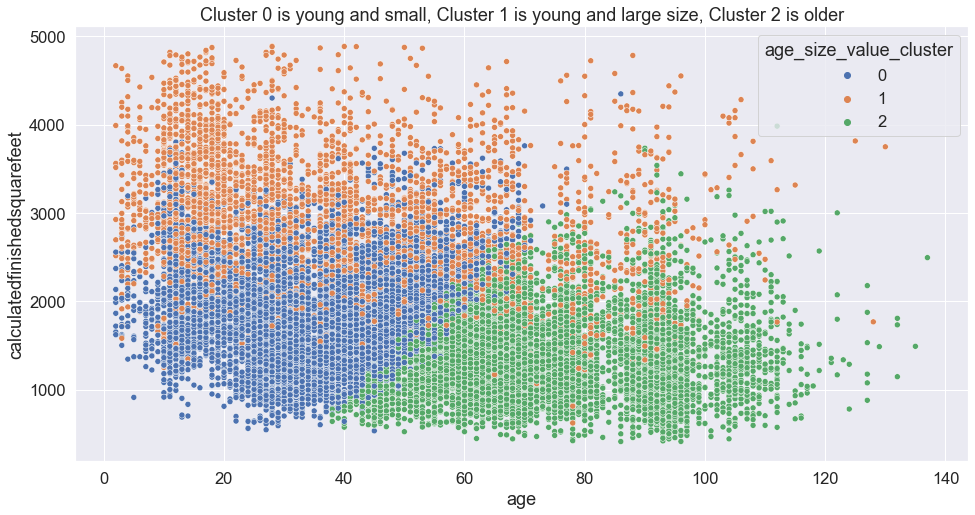

In [48]:
# Unscaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'age', y='calculatedfinishedsquarefeet', hue='age_size_value_cluster')
plt.title("Cluster 0 is young and small, Cluster 1 is young and large size, Cluster 2 is older")

Text(0.5, 1.0, 'Cluster 0 is young and small, Cluster 1 is young and large size, Cluster 2 is older')

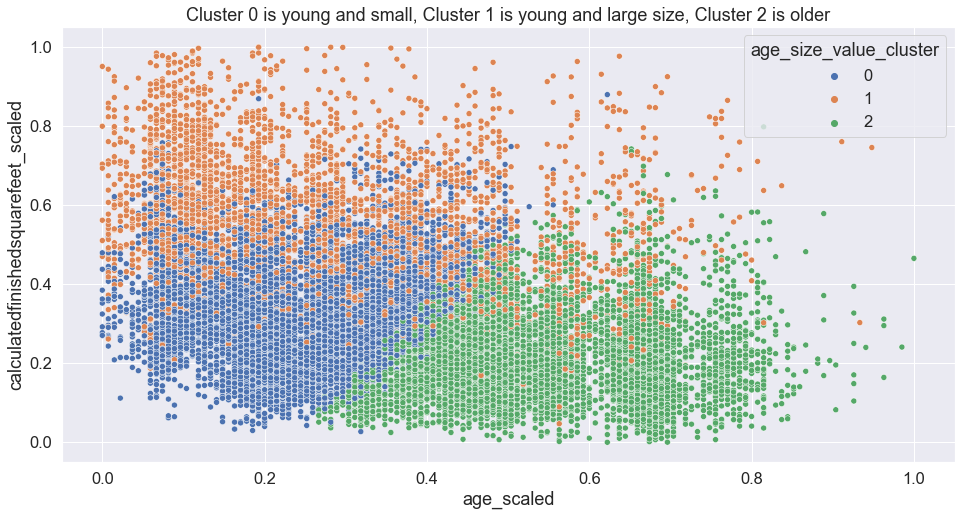

In [49]:
# Scaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'age_scaled', y='calculatedfinishedsquarefeet_scaled', hue='age_size_value_cluster')
plt.title("Cluster 0 is young and small, Cluster 1 is young and large size, Cluster 2 is older")

Text(0.5, 1.0, 'Cluster 0 is young and low value, Cluster 1 is young and High value, Cluster 2 is older')

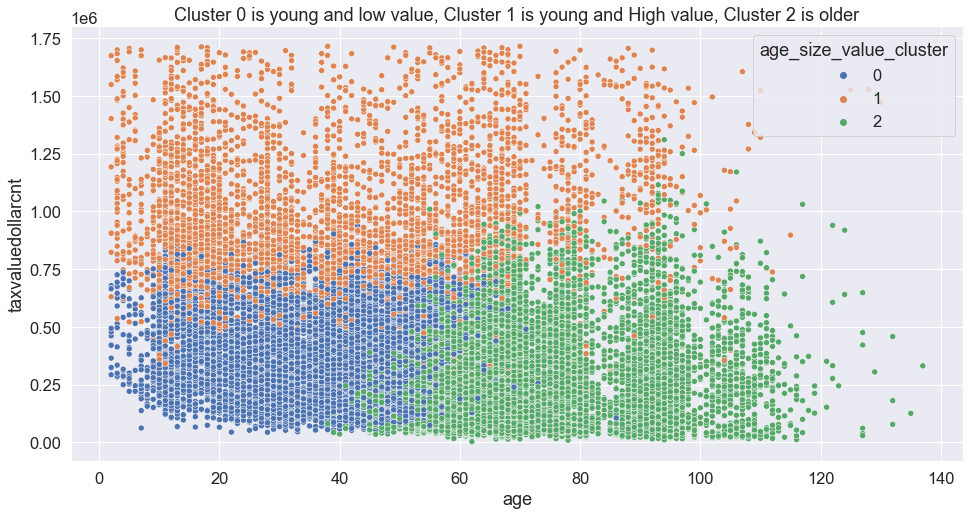

In [50]:
# Unscaled data and clusters
sns.scatterplot(data = train_scaled, x = 'age', y='taxvaluedollarcnt', hue='age_size_value_cluster')
plt.title("Cluster 0 is young and low value, Cluster 1 is young and High value, Cluster 2 is older")

Text(0.5, 1.0, 'Cluster 0 is young and low value, Cluster 1 is young and High value, Cluster 2 is older')

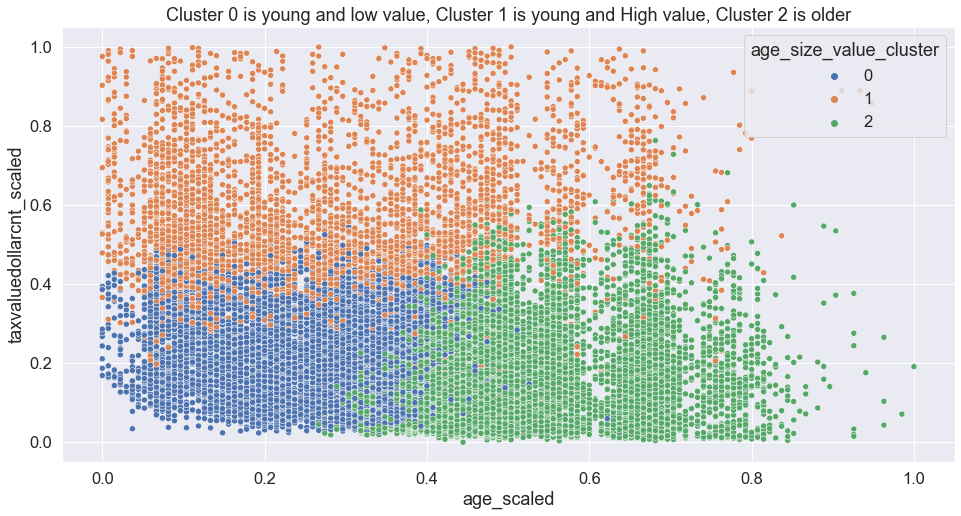

In [51]:
# Scaled data and clusters
sns.scatterplot(data = train_scaled, x = 'age_scaled', y='taxvaluedollarcnt_scaled', hue='age_size_value_cluster')
plt.title("Cluster 0 is young and low value, Cluster 1 is young and High value, Cluster 2 is older")

Text(0.5, 1.0, 'Cluster 0 is young and low value, Cluster 1 is young and High value, Cluster 2 is older')

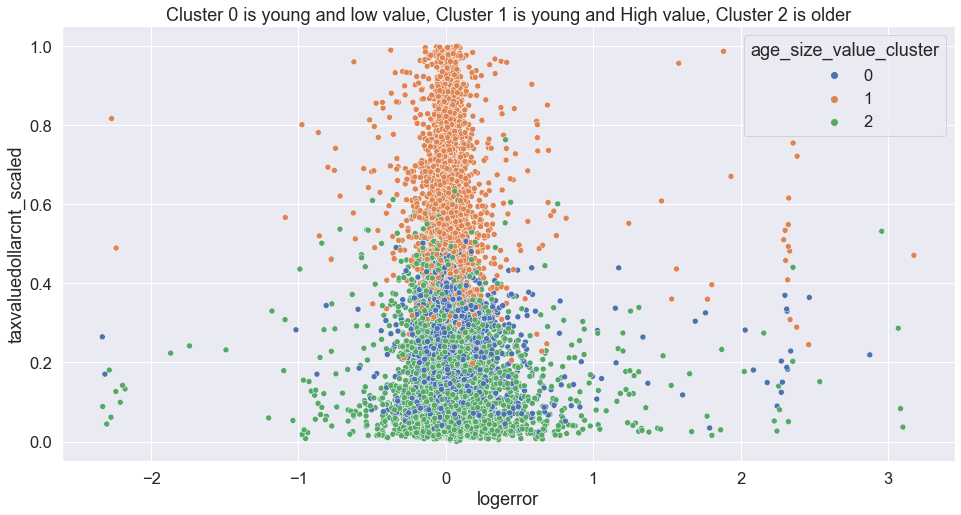

In [69]:
# Scaled data and clusters - look at logerror
sns.scatterplot(data = train_scaled, x = 'logerror', y='taxvaluedollarcnt_scaled', hue='age_size_value_cluster')
plt.title("Cluster 0 is young and low value, Cluster 1 is young and High value, Cluster 2 is older")

### Cluster by price Scale (Value)

In [52]:
X = train_scaled[price_scale]

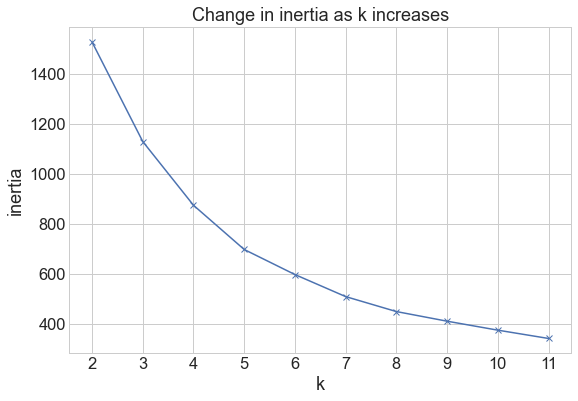

In [53]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### K=5

In [54]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

train_scaled['value_cluster'] = kmeans.predict(X)
train_scaled.age_size_value_cluster = train_scaled.age_size_value_cluster.astype('category')

Text(0.5, 0, 'Cluster')

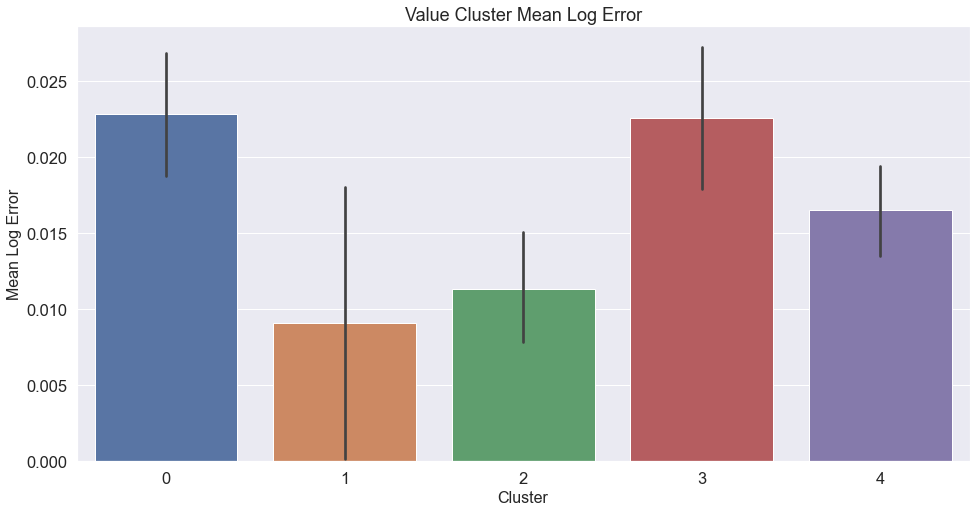

In [55]:
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'value_cluster', y='logerror')
plt.title("Value Cluster Mean Log Error")
plt.ylabel("Mean Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

In [63]:
overall_mean = train_scaled.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.value_cluster):
    sample = train_scaled[train_scaled.value_cluster==col]
    t, p = stats.ttest_1samp(sample.logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.017734656591149353
0 Significant?  True t value:  2.582790682324217
1 Significant?  False t value:  -1.9502324466778003
2 Significant?  True t value:  -3.3419250315527633
3 Significant?  False t value:  1.9242530059489003
4 Significant?  False t value:  -0.8132300166257408


Text(0.5, 1.0, 'Cluster 0 is old and low, Cluster 1 is High, Cluster 3 is old and mid, Cluster 4 is Young and mid, Cluster 5 is Young and low')

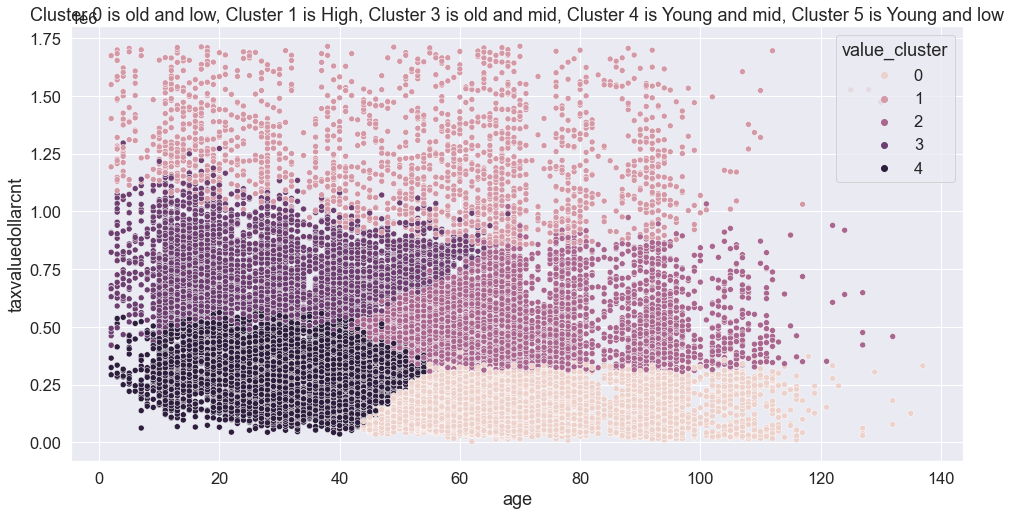

In [57]:
# Unscaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'age', y='taxvaluedollarcnt', hue='value_cluster')
plt.title("Cluster 0 is old and low, Cluster 1 is High, Cluster 3 is old and mid, Cluster 4 is Young and mid, Cluster 5 is Young and low")

Text(0.5, 1.0, 'Cluster 0 , Cluster 1, Cluster 2 all could be something, Cluster 4 and Cluster 5 not valuable')

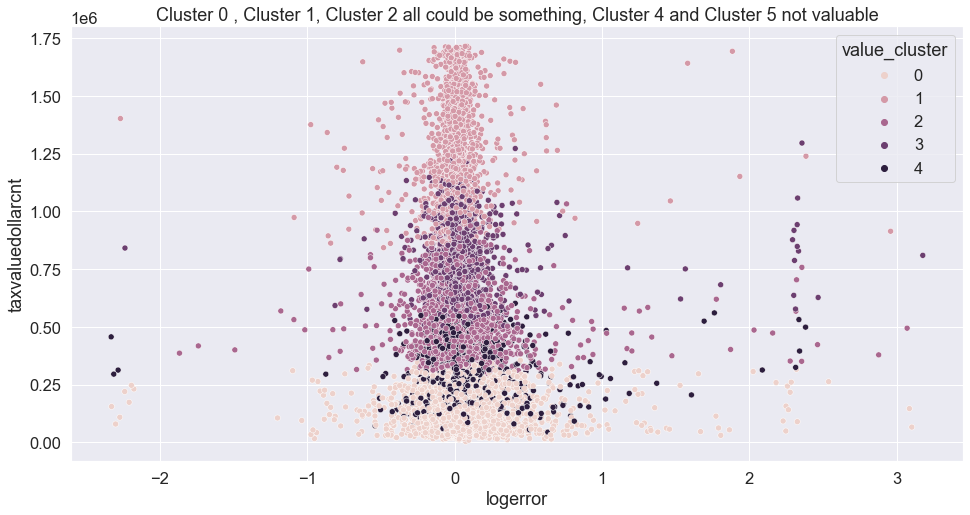

In [68]:
# Unscaled data based on clusters - Looking at logerror
sns.scatterplot(data = train_scaled, x = 'logerror', y='taxvaluedollarcnt', hue='value_cluster')
plt.title("Cluster 0 , Cluster 1, Cluster 2 all could be something, Cluster 4 and Cluster 5 not valuable")

### On Home data (home_scale)

In [58]:
X = train_scaled[home_scale]

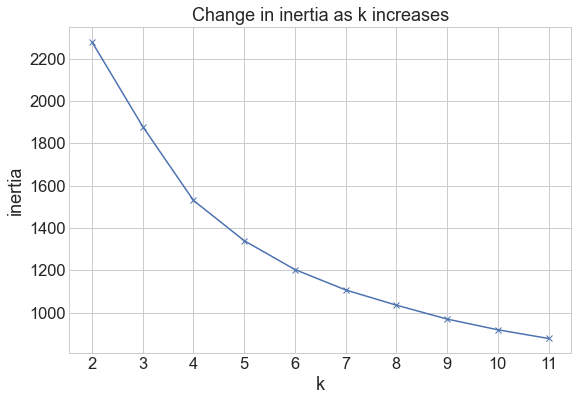

In [59]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### K=4

In [60]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

train_scaled['home_cluster'] = kmeans.predict(X)
train_scaled.home_cluster = train_scaled.home_cluster.astype('category')

Text(0.5, 0, 'Cluster')

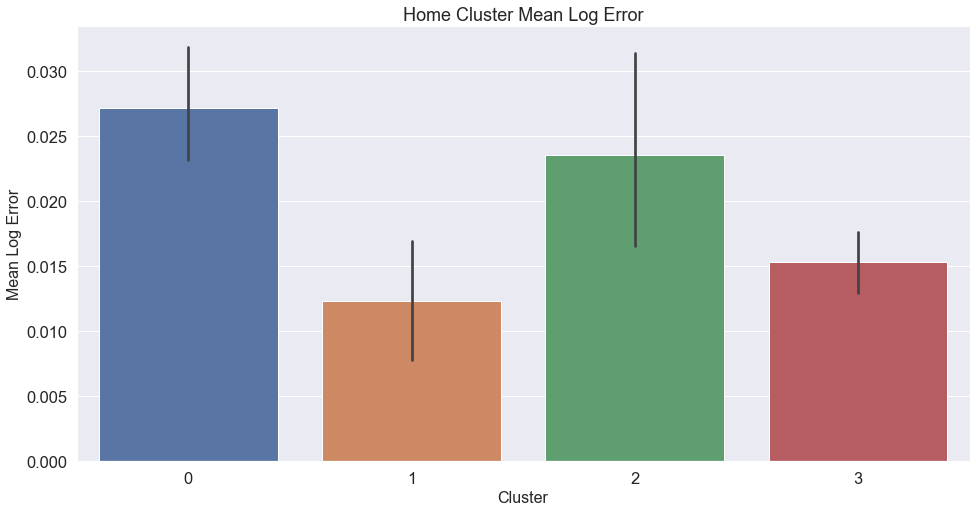

In [61]:
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'home_cluster', y='logerror')
plt.title("Home Cluster Mean Log Error")
plt.ylabel("Mean Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

In [62]:
overall_mean = train_scaled.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.home_cluster):
    sample = train_scaled[train_scaled.home_cluster==col]
    t, p = stats.ttest_1samp(sample.logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.017734656591149353
0 Significant?  True t value:  4.204509189765621
1 Significant?  True t value:  -2.302433951553634
2 Significant?  False t value:  1.5289661817110194
3 Significant?  True t value:  -1.981747533584819


### Take away
 - Some significance.... lets plot and see what it looks like

Text(0.5, 1.0, 'Chaos version 1')

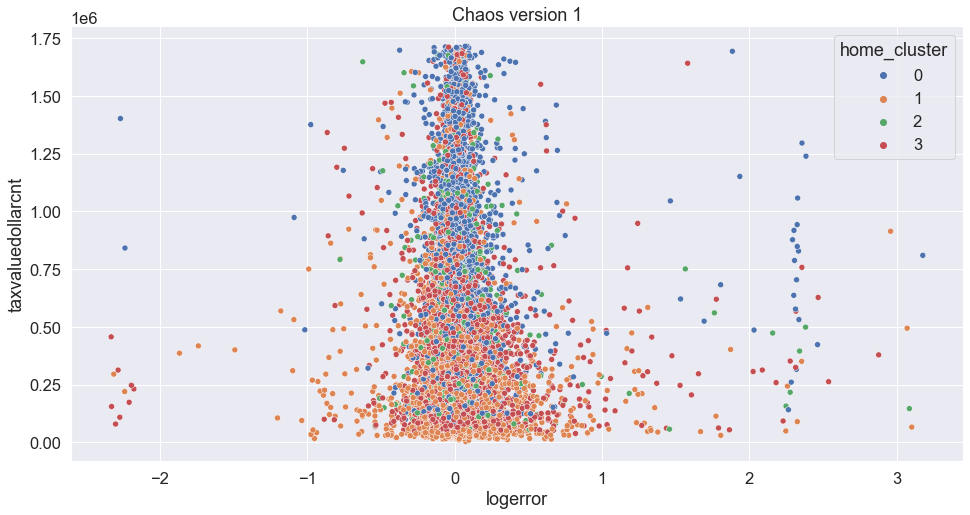

In [65]:
# Unscaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'logerror', y='taxvaluedollarcnt', hue='home_cluster')
plt.title("Chaos version 1")

Text(0.5, 1.0, 'More Chaos')

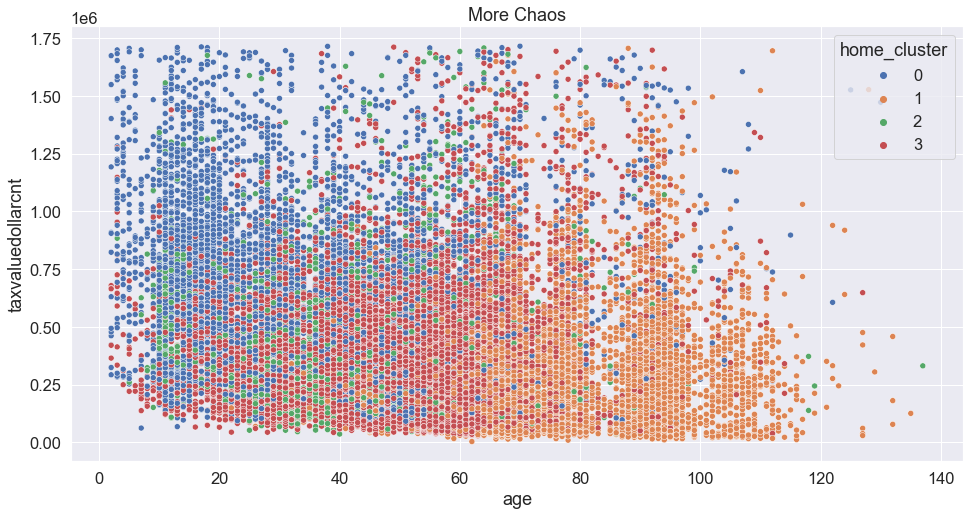

In [70]:
# Unscaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'age', y='taxvaluedollarcnt', hue='home_cluster')
plt.title("More Chaos")

### Takeaway
- Home Cluster had best statistical significance
- Home cluster has worst visual clusters

In [72]:
# Trying one more thing...All scaled items
train.columns[train.columns.str.contains("scale")]

Index([], dtype='object')